In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from category_encoders import TargetEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV, RandomizedSearchCV, train_test_split
from xgboost import XGBRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.neural_network import MLPRegressor

df = pd.read_csv('data_encoded.csv')

X = df.drop('overall_rating', axis=1)
y = df['overall_rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [2]:
# Preprocessing
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [3]:
base_learners = [
    ('svr', SVR(C=10, gamma='auto', kernel='rbf')),
    ('dt', DecisionTreeRegressor(ccp_alpha=0.0005, max_depth=16,
                                       min_samples_leaf=16, random_state=42)),
    ('knn', KNeighborsRegressor()),
    ('rf', RandomForestRegressor(random_state=42)),
    ('ada', AdaBoostRegressor(random_state=42)),
    ('gb', GradientBoostingRegressor(random_state=42)),
    ('xgb', XGBRegressor(random_state=42)),
    ('mlp', MLPRegressor(random_state=42, max_iter=500))
]

In [4]:
meta_learner = LinearRegression()

stack = StackingRegressor(
    estimators=base_learners, 
    final_estimator=meta_learner
)

stack.fit(X_train_scaled, y_train)

print(stack.score(X_test_scaled, y_test))

0.9410487785885621


In [5]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
def evaluate_model(model, X, y):
    y_pred = model.predict(X)
    mse = mean_squared_error(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    return mse, mae, r2

def print_metrics(mse, mae, r2):
    print(f'MSE: {mse:.3f}')
    print(f'MAE: {mae:.3f}')
    print(f'R2: {r2:.3f}')

In [6]:
y_train_pred = stack.predict(X_train_scaled)

print('Train Set:')
print_metrics(*evaluate_model(stack, X_train_scaled, y_train))

y_pred = stack.predict(X_test_scaled)

print('\nTest Set:')
print_metrics(*evaluate_model(stack, X_test_scaled, y_test))

Train Set:
MSE: 1.467
MAE: 0.613
R2: 0.970

Test Set:
MSE: 2.794
MAE: 0.954
R2: 0.941


In [27]:
predictions_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
})

print(predictions_df.head(10))

       Actual  Predicted
7341       64  63.593196
4585       83  82.507488
9676       59  60.253182
13889      63  62.471092
4779       58  58.310061
14781      74  73.491478
14044      68  68.627156
1318       75  75.187555
2325       70  70.209823
14499      57  57.599610


In [28]:
sorted_predictions_df = predictions_df.sort_index().reset_index(drop=True)
print(sorted_predictions_df.head())

   Actual  Predicted
0      56  55.593807
1      68  67.844390
2      67  66.957200
3      71  70.769381
4      64  63.935489


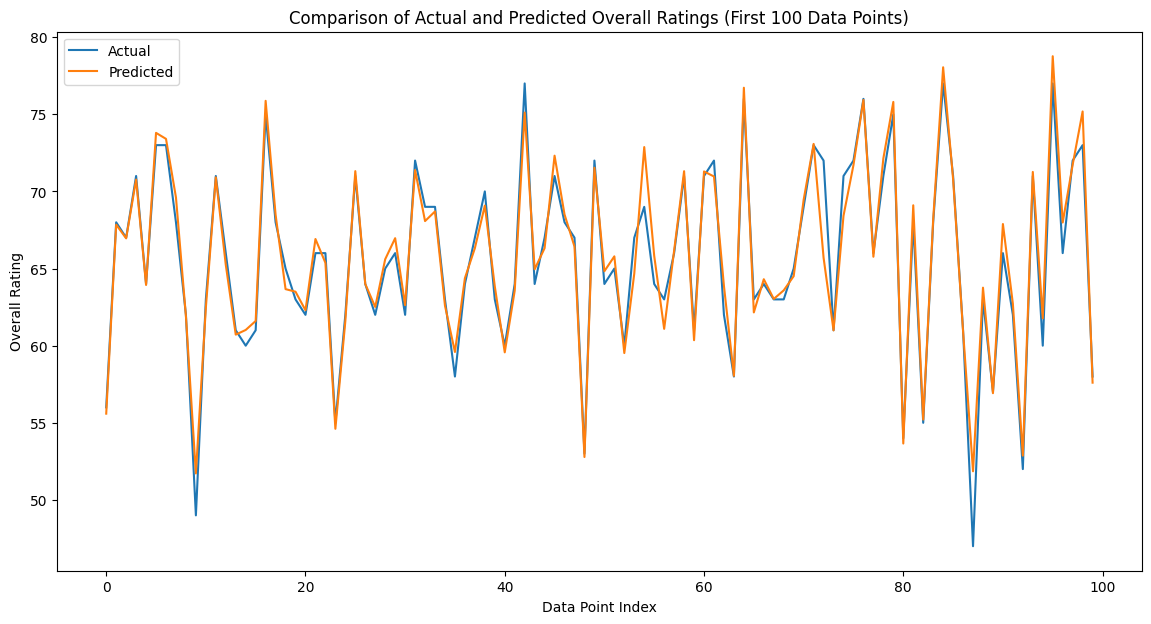

In [29]:
plt.figure(figsize=(14, 7))
plt.plot(sorted_predictions_df['Actual'][:100].values, label='Actual')
plt.plot(sorted_predictions_df['Predicted'][:100].values, label='Predicted')
plt.xlabel('Data Point Index')
plt.ylabel('Overall Rating')
plt.title('Comparison of Actual and Predicted Overall Ratings (First 100 Data Points)')
plt.legend()
plt.show()